In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
label_def_similar = {'background': 0, 'f/s20/40_20/40_B/G': 1, 'm20_100': 2, 'm20/30': 3, 'r20': 4, 
             'bearing_box': 5, 'bearing': 6, 'axis': 7, 'distance_tube': 8, 'motor': 9, 
             'container': 10, 'em_01': 11, 'em_02': 12}

label_def_full = {'background': 0, 'f20_20_B': 1, 's40_40_B': 2, 'f20_20_G': 3, 's40_40_G': 4,  
             'm20_100': 5, 'm20': 6, 'm30': 7, 'r20': 8, 'bearing_box_ax01': 9, 'bearing': 10, 'axis': 11, 
             'distance_tube': 12, 'motor': 13, 'container_box_blue': 14, 'container_box_red': 15, 
             'bearing_box_ax16': 16, 'em_01': 17, 'em_02': 18}

label_def_size_invariant = {'background': 0, 'f/s20/40_20/40_B': 1, 'f/s20/40_20/40_G': 2,
                            'm20_100': 3, 'm20/30': 4, 'r20': 5, 'bearing_box': 6, 
                            'bearing': 7, 'axis': 8, 'distance_tube': 9, 'motor': 10, 'container_box_blue': 11, 
                            'container_box_red': 12, 'em_01': 13, 'em_02': 14}

label_def_binary = {'background': 0, 'foreground': 1}

variant_to_label_def = {'full': label_def_full, 'binary': label_def_binary,
                                     'similar': label_def_similar, 
                                     'size_invariant': label_def_size_invariant}

In [3]:
class DataAnalysis():
    
    def __init__(self, VARIANT='full', LABEL_PATH='./objects/real_augmented/training/label'):
        
        self.variant = VARIANT
        self.label_path = LABEL_PATH
        self.label_def = variant_to_label_def[VARIANT]
        
        file_paths = self.read_labels()
        self.image_to_cls_to_pixelCount = self.initialize_data_dict()
        self.total_pixels = self.get_total_pixels(file_paths)
        self.populate_data_dict(file_paths)
    
    def read_labels(self):
            
        return [os.path.join(self.label_path, file) for file in
               os.listdir(self.label_path)]
    
    def initialize_data_dict(self):
        
        image_to_cls_to_pixelCount = {}
        cls_to_pixelCount = {key:0 for key in range(len(self.label_def))}
        for file in os.listdir(self.label_path):
            image_to_cls_to_pixelCount[file] = cls_to_pixelCount.copy()
            
        return image_to_cls_to_pixelCount
    
    def get_total_pixels(self, file_paths):
        
        img_dimension = cv2.imread(file_paths[0], 0).shape
        return img_dimension[0]*img_dimension[1]*len(file_paths)
    
    def populate_data_dict(self, file_paths):
        
        for file in file_paths:
            img = cv2.imread(file, 0)
            clses = np.unique(img)
            img_name = file.split('/')[-1]

            for cls in clses:      
                self.image_to_cls_to_pixelCount[img_name][cls] = np.shape(
                                                        np.argwhere(img==cls))[0]

            if sum(self.image_to_cls_to_pixelCount[img_name].values()
                                      ) != img.shape[0]*img.shape[1]:
                raise ValueError('Not all pixels have been counted...')
                
    def get_cls_to_percentage(self):
        
        cls_to_percentage = {key:0 for key in self.label_def.keys()}
        for count_dict in self.image_to_cls_to_pixelCount.values():
            for key in cls_to_percentage.keys():
                cls_to_percentage[key] += count_dict.get(self.label_def[key], 0)

        return {key:(value/self.total_pixels)*100 for key, value in 
                                            cls_to_percentage.items()}
    
    def plot_cls_to_x(self, cls_to_x, y_label):
        
        figure = plt.figure(figsize=(15, 5))
        plt.bar(cls_to_x.keys(), cls_to_x.values())
        plt.xlabel('class name', fontsize= 20)
        plt.ylabel(y_label, fontsize= 20)
        plt.title('VARIANT: {}'.format(self.variant),
                 fontsize= 20)
        plt.xticks(rotation=80)
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.show()
        
    def get_cls_to_weight(self, cls_to_percentage, set_background_weight=None):
        
        cls_to_weight = {key: round(len(self.label_def)/(100*value),4)
                         for key, value in cls_to_percentage.items()}

        normalizer = sum(cls_to_weight.values()) - cls_to_weight['background']
        
        if set_background_weight is None:
            background_weight = cls_to_weight['background']  
        else:
            background_weight = set_background_weight

        cls_to_weight = {key: round(value*(1 - background_weight)/normalizer, 4) 
                         if key is not 'background'
                        else background_weight for key, value in cls_to_weight.items()}

        if 1. - sum(cls_to_weight.values()) > 1e-10:
            raise ValueError (
                'The sum of weights is {}... The weights have not been normalized...'.
                format(sum(cls_to_weight.values())))

        return cls_to_weight
    
    def get_weight_list(self, cls_to_weight):
        
        weight_list = np.zeros(len(self.label_def))
        for label in self.label_def.keys():
            weight_list[self.label_def[label]] = cls_to_weight[label]

        return list(weight_list)
    
    def get_cls_to_count(self, cls_to_weight):
        
        cls_to_count = {key:0 for key in range(len(self.label_def))}
        for count_dict in self.image_to_cls_to_pixelCount.values():
            cls_to_count = {key: value + 1 if count_dict[key]!=0 
                            else value for key, value in cls_to_count.items()}
            
        cls_to_count = {key: cls_to_count[self.label_def[key]] for 
                        key in cls_to_weight.keys()}
            
        return cls_to_count

In [4]:
analyzer = DataAnalysis(VARIANT='full', LABEL_PATH='./objects/real_augmented/training/label')

Percentage of pixels occupied by each class: 

{'background': 95.00944421427819, 'f20_20_B': 0.1272819339225589, 's40_40_B': 0.17863942155934343, 'f20_20_G': 0.141477437131734, 's40_40_G': 0.3160355179398148, 'm20_100': 0.18967096091119529, 'm20': 0.11005481244739058, 'm30': 0.1464539601746633, 'r20': 0.14271375868055555, 'bearing_box_ax01': 0.28881671533038716, 'bearing': 0.10252426609848485, 'axis': 0.14078776041666666, 'distance_tube': 0.033371639572811446, 'motor': 0.24572466198442758, 'container_box_blue': 0.8168164391308923, 'container_box_red': 0.8014972314288721, 'bearing_box_ax16': 0.19950563578493263, 'em_01': 0.46222067682028617, 'em_02': 0.5469629563867845}


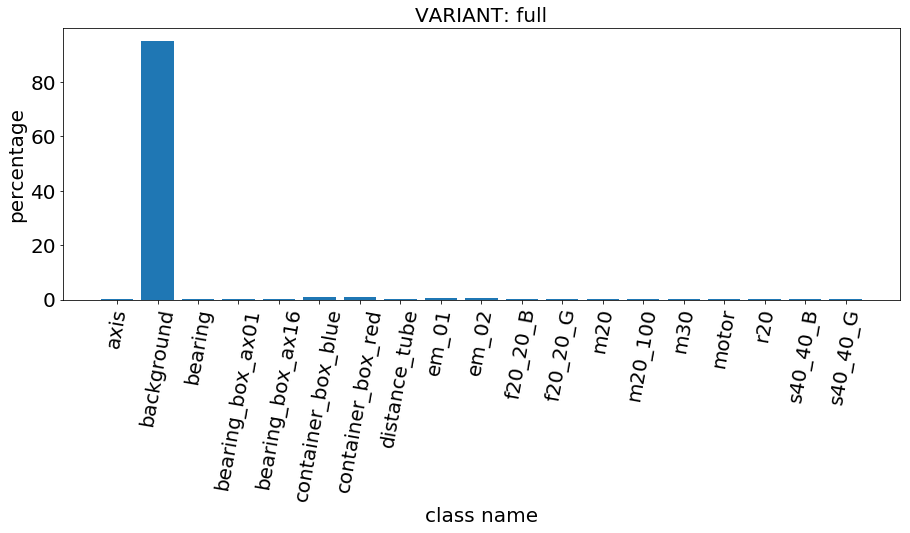

In [5]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: \n')
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

Calculated weight coefficient of each class: 

{'background': 0.002, 'f20_20_B': 0.0666, 's40_40_B': 0.0475, 'f20_20_G': 0.0599, 's40_40_G': 0.0268, 'm20_100': 0.0447, 'm20': 0.077, 'm30': 0.0579, 'r20': 0.0594, 'bearing_box_ax01': 0.0294, 'bearing': 0.0827, 'axis': 0.0602, 'distance_tube': 0.2541, 'motor': 0.0345, 'container_box_blue': 0.0104, 'container_box_red': 0.0106, 'bearing_box_ax16': 0.0425, 'em_01': 0.0183, 'em_02': 0.0155} 

List of weights: 
 [0.002, 0.0666, 0.0475, 0.0599, 0.0268, 0.0447, 0.077, 0.0579, 0.0594, 0.0294, 0.0827, 0.0602, 0.2541, 0.0345, 0.0104, 0.0106, 0.0425, 0.0183, 0.0155] 

List of weights obtained by calling DataAnalysis(): 
 [0.002, 0.0666, 0.0475, 0.0599, 0.0268, 0.0447, 0.077, 0.0579, 0.0594, 0.0294, 0.0827, 0.0602, 0.2541, 0.0345, 0.0104, 0.0106, 0.0425, 0.0183, 0.0155]


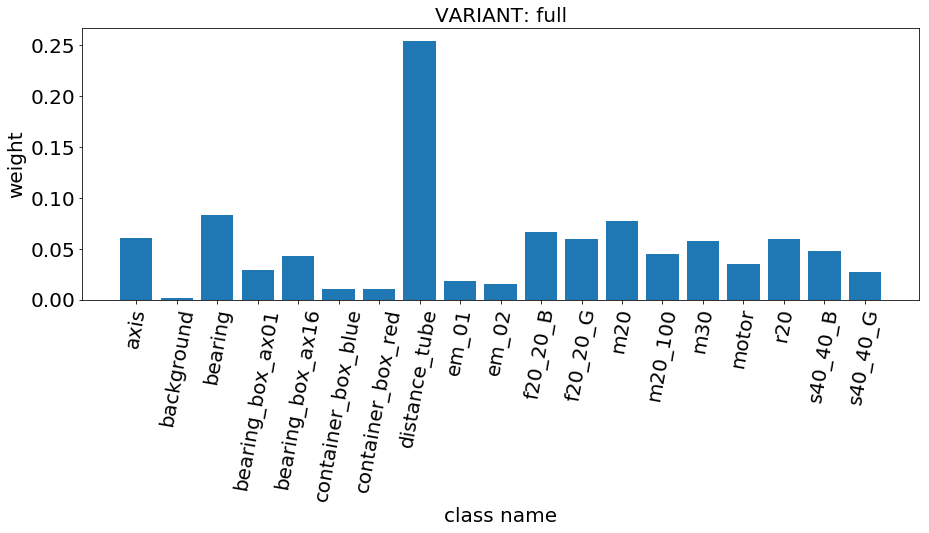

In [6]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage)
print ('Calculated weight coefficient of each class: \n')
print (cls_to_weight,'\n')
print ('List of weights: \n', list(cls_to_weight.values()), '\n')
print ('List of weights obtained by calling DataAnalysis(): \n', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

Count of objects of each class: 

{'background': 396, 'f20_20_B': 22, 's40_40_B': 22, 'f20_20_G': 22, 's40_40_G': 22, 'm20_100': 22, 'm20': 22, 'm30': 22, 'r20': 22, 'bearing_box_ax01': 22, 'bearing': 22, 'axis': 22, 'distance_tube': 22, 'motor': 22, 'container_box_blue': 22, 'container_box_red': 22, 'bearing_box_ax16': 22, 'em_01': 22, 'em_02': 22}


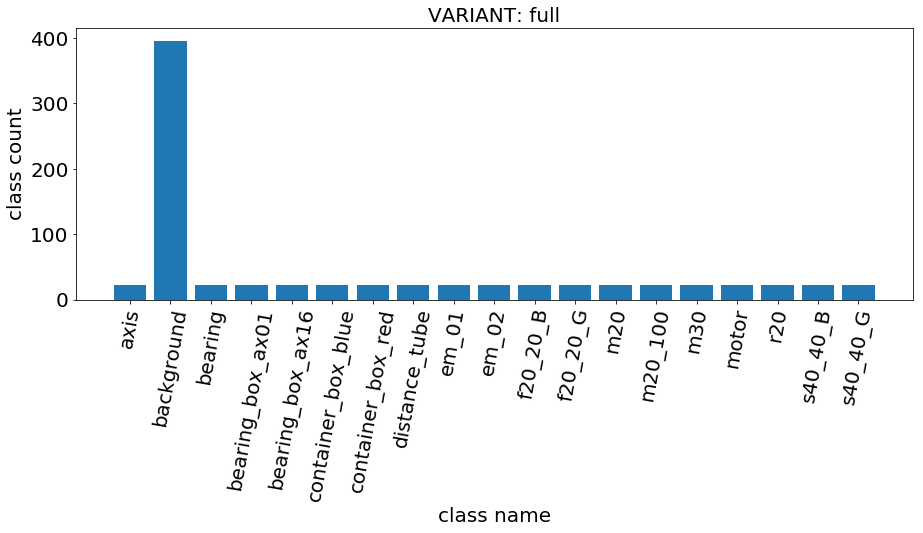

In [7]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: \n')
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')

In [8]:
analyzer = DataAnalysis(VARIANT='similar', LABEL_PATH='./objects/real_augmented/training/label_similar')

Percentage of pixels occupied by each class: 

{'background': 95.00944421427819, 'f/s20/40_20/40_B/G': 0.7634343105534511, 'm20_100': 0.18967096091119529, 'm20/30': 0.25650877262205385, 'r20': 0.14271375868055555, 'bearing_box': 0.48832235111531985, 'bearing': 0.10252426609848485, 'axis': 0.14078776041666666, 'distance_tube': 0.033371639572811446, 'motor': 0.24572466198442758, 'container': 1.6183136705597643, 'em_01': 0.46222067682028617, 'em_02': 0.5469629563867845}


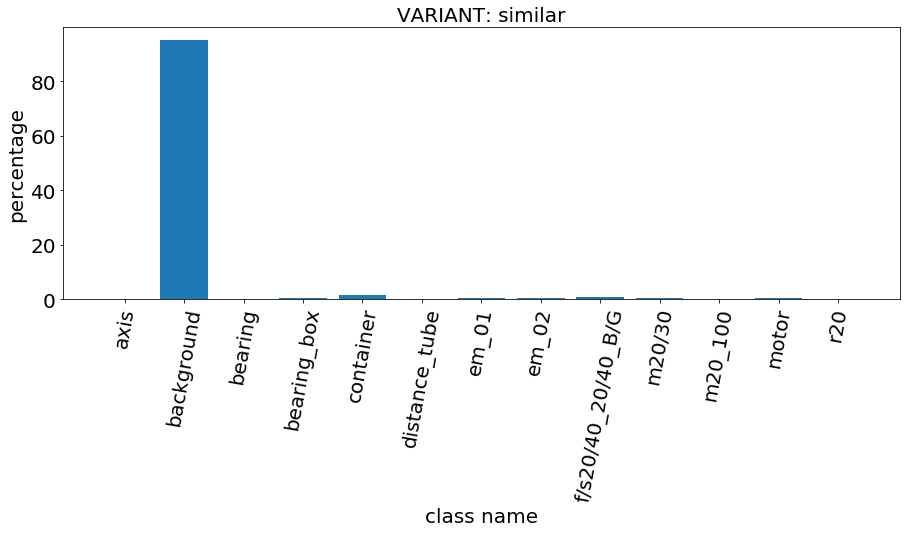

In [9]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: \n')
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

Calculated weight coefficient of each class: 

{'background': 0.0014, 'f/s20/40_20/40_B/G': 0.0174, 'm20_100': 0.0702, 'm20/30': 0.0519, 'r20': 0.0932, 'bearing_box': 0.0273, 'bearing': 0.1298, 'axis': 0.0945, 'distance_tube': 0.3988, 'motor': 0.0542, 'container': 0.0082, 'em_01': 0.0288, 'em_02': 0.0243} 

List of weights: 
 [0.0014, 0.0174, 0.0702, 0.0519, 0.0932, 0.0273, 0.1298, 0.0945, 0.3988, 0.0542, 0.0082, 0.0288, 0.0243] 

List of weights obtained by calling DataAnalysis(): 
 [0.0014, 0.0174, 0.0702, 0.0519, 0.0932, 0.0273, 0.1298, 0.0945, 0.3988, 0.0542, 0.0082, 0.0288, 0.0243]


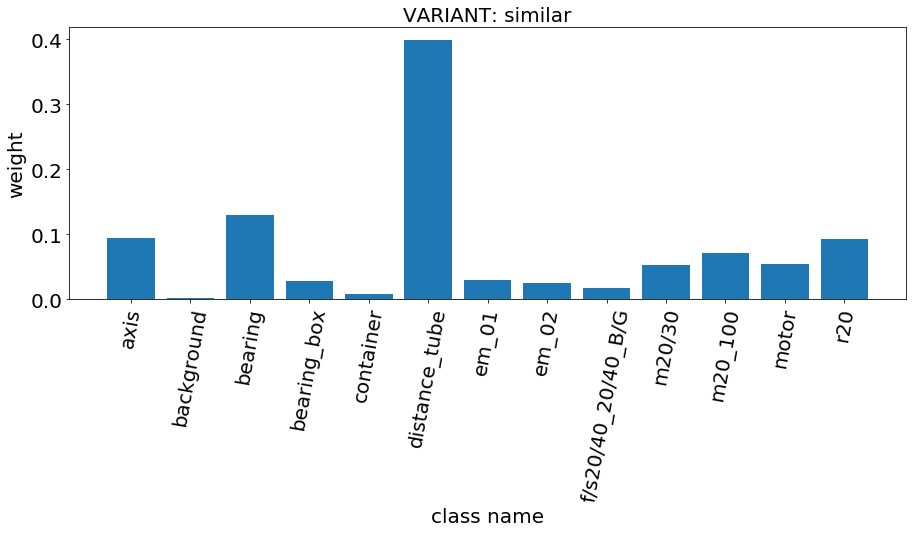

In [10]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage)
print ('Calculated weight coefficient of each class: \n')
print (cls_to_weight, '\n')
print ('List of weights: \n', list(cls_to_weight.values()), '\n')
print ('List of weights obtained by calling DataAnalysis(): \n', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

Count of objects of each class: 

{'background': 396, 'f/s20/40_20/40_B/G': 88, 'm20_100': 22, 'm20/30': 44, 'r20': 22, 'bearing_box': 44, 'bearing': 22, 'axis': 22, 'distance_tube': 22, 'motor': 22, 'container': 44, 'em_01': 22, 'em_02': 22}


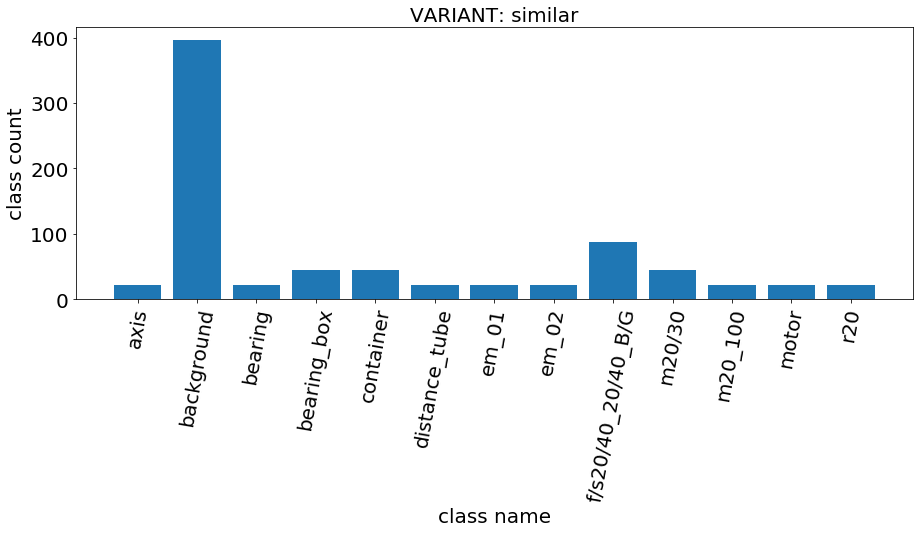

In [11]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: \n')
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')

In [12]:
analyzer = DataAnalysis(VARIANT='size_invariant', LABEL_PATH='./objects/real_augmented/training/label_size_invariant')

Percentage of pixels occupied by each class: 

{'background': 95.00944421427819, 'f/s20/40_20/40_B': 0.30592135548190236, 'f/s20/40_20/40_G': 0.45751295507154877, 'm20_100': 0.18967096091119529, 'm20/30': 0.25650877262205385, 'r20': 0.14271375868055555, 'bearing_box': 0.48832235111531985, 'bearing': 0.10252426609848485, 'axis': 0.14078776041666666, 'distance_tube': 0.033371639572811446, 'motor': 0.24572466198442758, 'container_box_blue': 0.8168164391308923, 'container_box_red': 0.8014972314288721, 'em_01': 0.46222067682028617, 'em_02': 0.5469629563867845}


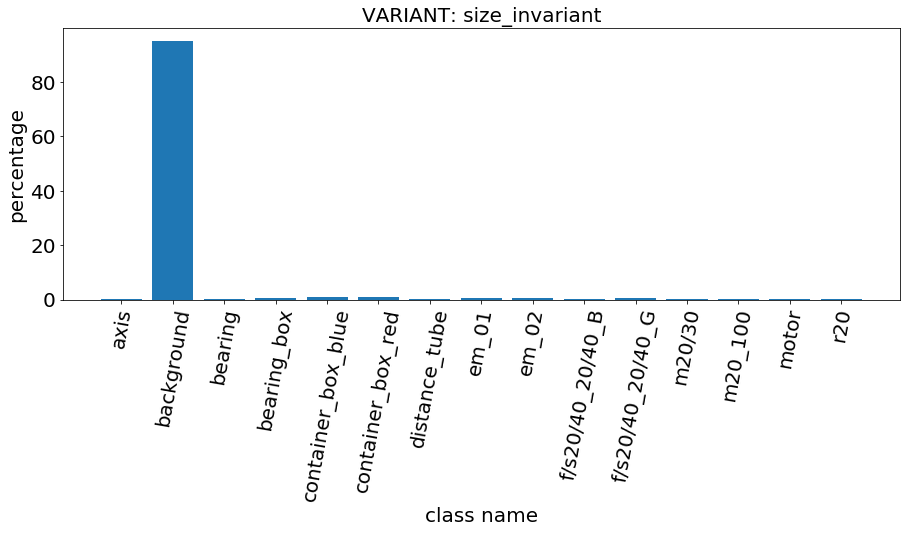

In [13]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: \n')
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

Calculated weight coefficient of each class: 

{'background': 0.0016, 'f/s20/40_20/40_B': 0.0403, 'f/s20/40_20/40_G': 0.0269, 'm20_100': 0.065, 'm20/30': 0.048, 'r20': 0.0863, 'bearing_box': 0.0252, 'bearing': 0.1202, 'axis': 0.0875, 'distance_tube': 0.3692, 'motor': 0.0501, 'container_box_blue': 0.0151, 'container_box_red': 0.0154, 'em_01': 0.0267, 'em_02': 0.0225} 

List of weights: 
 [0.0016, 0.0403, 0.0269, 0.065, 0.048, 0.0863, 0.0252, 0.1202, 0.0875, 0.3692, 0.0501, 0.0151, 0.0154, 0.0267, 0.0225] 

List of weights obtained by calling DataAnalysis(): 
 [0.0016, 0.0403, 0.0269, 0.065, 0.048, 0.0863, 0.0252, 0.1202, 0.0875, 0.3692, 0.0501, 0.0151, 0.0154, 0.0267, 0.0225]


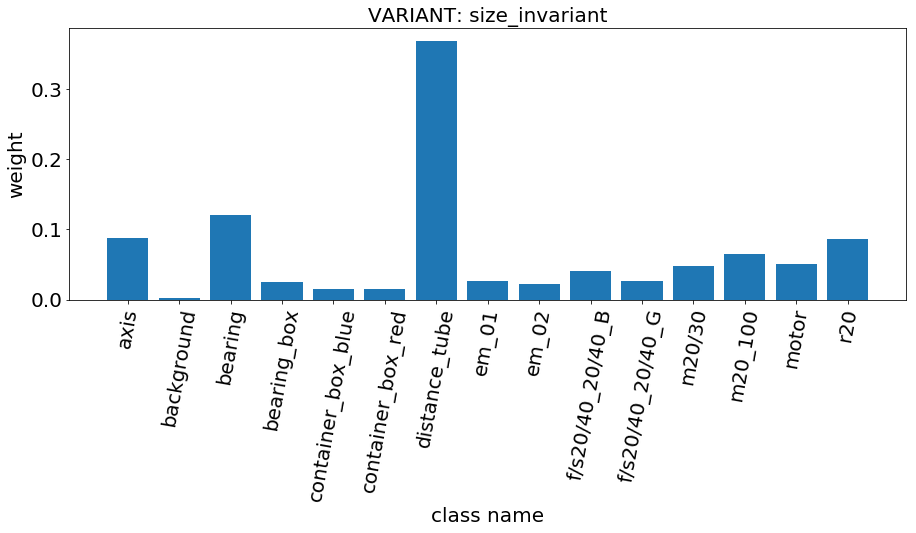

In [14]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage)
print ('Calculated weight coefficient of each class: \n')
print (cls_to_weight, '\n')
print ('List of weights: \n', list(cls_to_weight.values()), '\n')
print ('List of weights obtained by calling DataAnalysis(): \n', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

Count of objects of each class: 

{'background': 396, 'f/s20/40_20/40_B': 44, 'f/s20/40_20/40_G': 44, 'm20_100': 22, 'm20/30': 44, 'r20': 22, 'bearing_box': 44, 'bearing': 22, 'axis': 22, 'distance_tube': 22, 'motor': 22, 'container_box_blue': 22, 'container_box_red': 22, 'em_01': 22, 'em_02': 22}


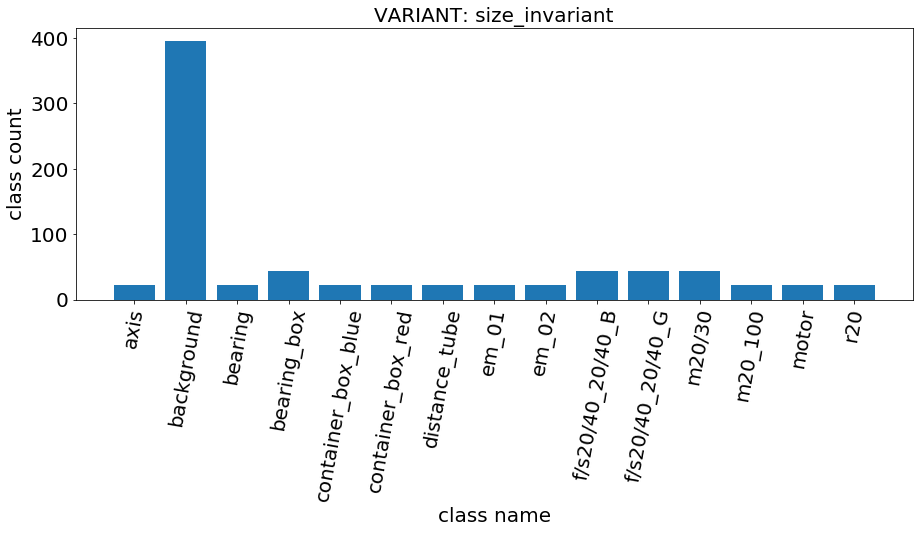

In [15]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: \n')
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')

In [16]:
analyzer = DataAnalysis(VARIANT='binary', LABEL_PATH='./objects/real_augmented/training/label_binary')

Percentage of pixels occupied by each class: 

{'background': 95.00944421427819, 'foreground': 4.990555785721802}


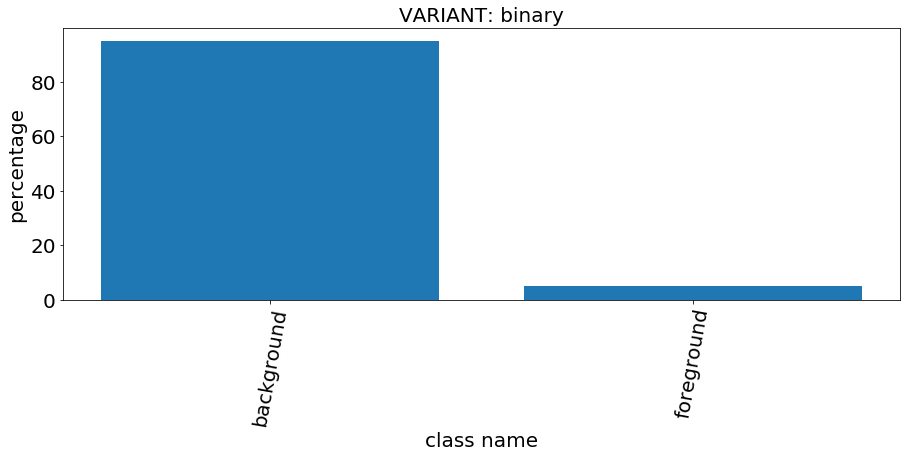

In [17]:
cls_to_percentage = analyzer.get_cls_to_percentage()
print ('Percentage of pixels occupied by each class: \n')
print (cls_to_percentage)
analyzer.plot_cls_to_x(cls_to_percentage, 'percentage')

Calculated weight coefficient of each class: 

{'background': 0.0002, 'foreground': 0.9998} 

List of weights: 
 [0.0002, 0.9998] 

List of weights obtained by calling DataAnalysis(): 
 [0.0002, 0.9998]


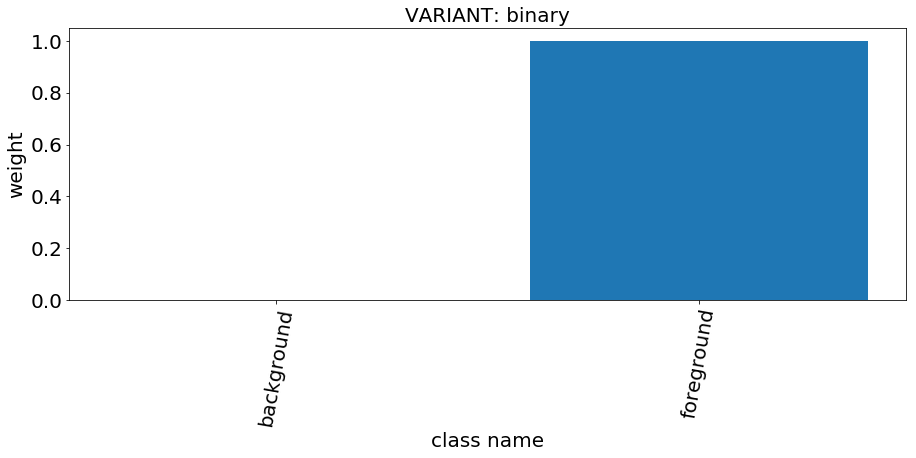

In [18]:
cls_to_weight = analyzer.get_cls_to_weight(cls_to_percentage)
print ('Calculated weight coefficient of each class: \n')
print (cls_to_weight, '\n')
print ('List of weights: \n', list(cls_to_weight.values()), '\n')
print ('List of weights obtained by calling DataAnalysis(): \n', 
       analyzer.get_weight_list(cls_to_weight))
analyzer.plot_cls_to_x(cls_to_weight, 'weight')

Count of objects of each class: 

{'background': 396, 'foreground': 396}


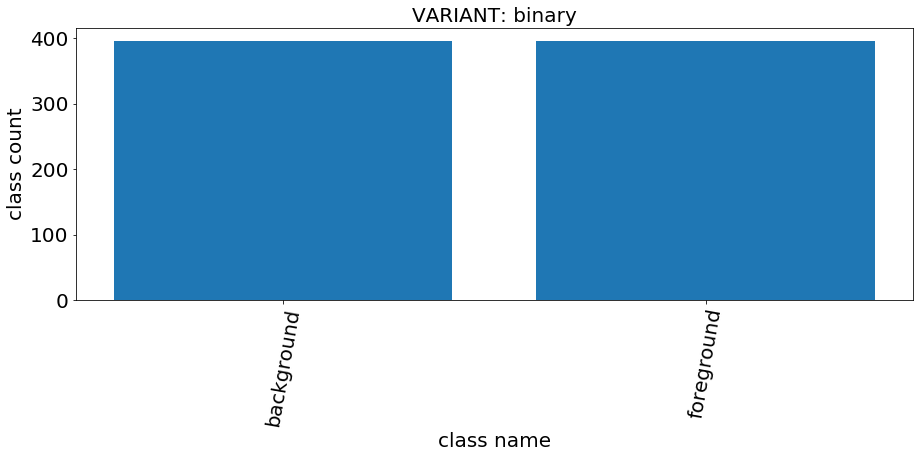

In [19]:
cls_to_count = analyzer.get_cls_to_count(cls_to_weight)
print ('Count of objects of each class: \n')
print (cls_to_count)
analyzer.plot_cls_to_x(cls_to_count, 'class count')